In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt, sosfreqz

### Function definitions

In [2]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', output='sos')
    return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfiltfilt(sos, data)
    return y

def stringToNP(row):
    return np.fromstring(row['data'], dtype=np.float64, sep=',')[:256]

def applyFilter(row, lowcut, highcut, fs, order=5):
    return butter_bandpass_filter(row['data'], lowcut, highcut, fs, order=order)

### Loading data and set parameters for preprocessing

In [3]:
# loadDataFrom = '../data/EP_30.txt'
loadDataFrom = '../data/EP1.01.txt'
storeTensorsTo = "processedData/channelSlectedBandPassed/npy/"
columns = ['id', 'event', 'device', 'channel', 'code', 'size', 'data']
channelToConsider = pd.Series(['P7', 'P8', 'T7', 'T8'])
dF = pd.read_csv(filepath_or_buffer=loadDataFrom, sep='\s+', names=columns)
dF.head(5)

,id,event,device,channel,code,size,data
0,67635,67635,EP,AF3,6,260,"4395.384615,4382.564102,4377.435897,4387.17948..."
1,67636,67635,EP,F7,6,260,"4489.230769,4475.384615,4474.358974,4486.66666..."
2,67637,67635,EP,F3,6,260,"4538.461538,4528.717948,4524.615384,4526.15384..."
3,67638,67635,EP,FC5,6,260,"4207.692307,4205.641025,4200.512820,4194.35897..."
4,67639,67635,EP,T7,6,260,"4497.948717,4498.461538,4494.871794,4497.94871..."


### Performing some cleaning

1. Convert signal in string to numpy array
2. Ignore all channels that are not in `channelsToConsider`
3. Ignore signals having data less than 256 = sampling frquency * time
4. Ignore data with code == -1. (Where subject is thinking arbitrarily)

In [4]:
cleanDf = dF.drop(['id', 'device'], axis=1)
cleanDf['size'] = pd.to_numeric(cleanDf['size'])
cleanDf['event'] = pd.to_numeric(cleanDf['event'])
cleanDf['code'] = pd.to_numeric(cleanDf['code'])
cleanDf['data'] = cleanDf.apply(stringToNP, axis=1)
cleanDf['size'] = cleanDf.apply(lambda row: row['data'].shape[0], axis=1)
cleanDf.drop(cleanDf[cleanDf['code'] == -1].index, inplace=True)
cleanDf = cleanDf[cleanDf['channel'].isin(channelToConsider)]
cleanDf = cleanDf[cleanDf['size'] == 256]
minSize = cleanDf['size'].min()
maxSize = cleanDf['size'].max()
minSize, maxSize

(256, 256)

In [5]:
cleanDf.head(10)

,event,channel,code,size,data
4,67635,T7,6,256,"[4497.948717, 4498.461538, 4494.871794, 4497.9..."
5,67635,P7,6,256,"[4203.076923, 4192.820512, 4194.871794, 4204.6..."
8,67635,P8,6,256,"[4245.641025, 4236.410256, 4218.461538, 4220.0..."
9,67635,T8,6,256,"[4506.666666, 4501.025641, 4496.923076, 4496.9..."
18,67636,T7,7,256,"[4498.974358, 4500.0, 4499.487179, 4494.871794..."
19,67636,P7,7,256,"[4194.358974, 4192.307692, 4191.794871, 4188.2..."
22,67636,P8,7,256,"[4228.205128, 4214.871794, 4211.282051, 4213.8..."
23,67636,T8,7,256,"[4507.692307, 4492.307692, 4484.102564, 4492.8..."
32,67637,T7,9,256,"[4488.717948, 4491.282051, 4492.820512, 4491.7..."
33,67637,P7,9,256,"[4195.384615, 4198.974358, 4202.051282, 4198.9..."


### Applying Band Pass filter

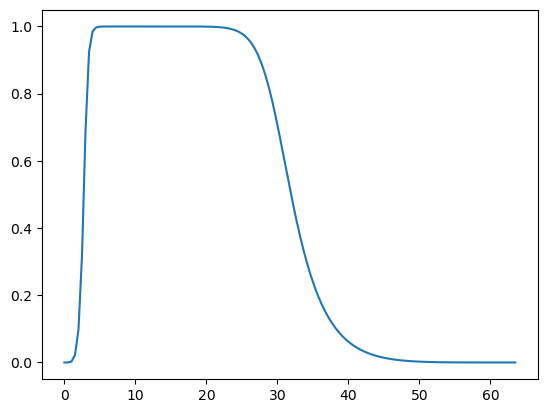

In [6]:
sampling_rate = 128
low_cut = 3
high_cut = 30
order = 5

sos = butter_bandpass(low_cut, high_cut, sampling_rate, order=order)
w, h = sosfreqz(sos, fs=sampling_rate, worN=129)
plt.plot(w, abs(h))
plt.show()

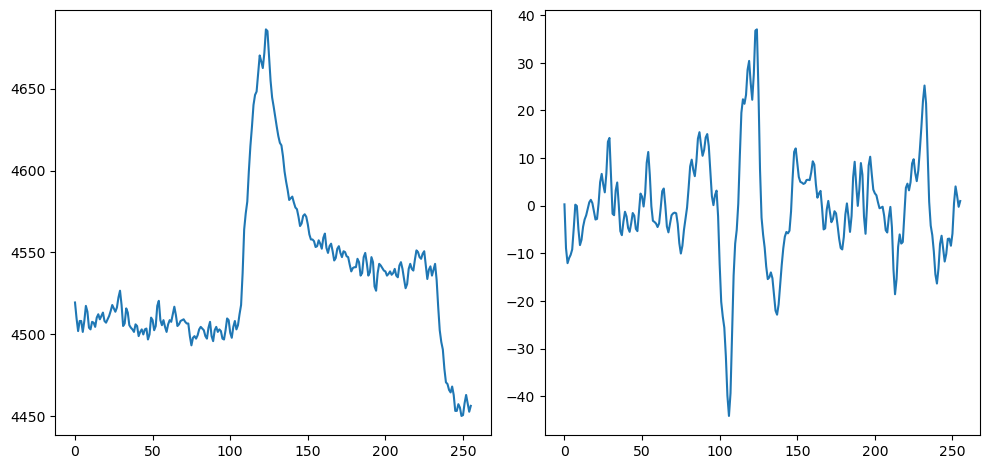

In [7]:
checkondata = 56
fig = plt.figure()
ax = fig.add_subplot(121)
ax.plot(cleanDf.iloc[checkondata]['data'])
y = cleanDf.iloc[checkondata]['data']
y = butter_bandpass_filter(y, low_cut, high_cut, sampling_rate, order=order)
ax = fig.add_subplot(122)
ax.plot(y)
fig.set_figwidth(10)
fig.tight_layout()
plt.show()

In [8]:
cleanDf['data'] = cleanDf.apply(applyFilter, axis=1, args=(low_cut, high_cut, sampling_rate, order))
cleanDf.head(10)

,event,channel,code,size,data
4,67635,T7,6,256,"[-0.21770093117688782, -3.099711209388541, -3...."
5,67635,P7,6,256,"[-0.12788652812583878, -8.654358538212257, -8...."
8,67635,P8,6,256,"[-0.032424944384704446, -13.840138022891418, -..."
9,67635,T8,6,256,"[-0.06908801830448685, -4.892770073145909, -8...."
18,67636,T7,7,256,"[-0.13788303988463135, 0.7121226656049529, -1...."
19,67636,P7,7,256,"[-0.18375266945528823, -1.5704942655173584, -3..."
22,67636,P8,7,256,"[-0.12915341203509811, -12.16866414027746, -17..."
23,67636,T8,7,256,"[-0.24993542633079713, -15.56952684251525, -20..."
32,67637,T7,9,256,"[-0.2699084747307685, 1.5959791590187482, 2.83..."
33,67637,P7,9,256,"[-0.17578778936526573, 4.482629318845906, 5.15..."


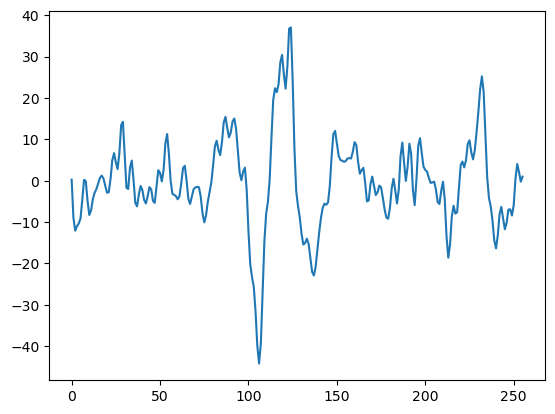

In [9]:
plt.plot(cleanDf.iloc[checkondata]['data'])
plt.show()

### Convert the filtered data as numpy arrays

In [10]:
events = cleanDf['event'].drop_duplicates().to_numpy()
numEvents = len(events)
targets = []
eventArrays = []

In [ ]:
# for event in events:
#     eventGroup = cleanDf.loc[cleanDf['event'] == event]
#     eventData = []
#     if channelToConsider.isin(eventGroup['channel']).all():
#         for channel in channelToConsider:
#             channelData = eventGroup.loc[eventGroup['channel'] == channel]['data'].values[0]
#             eventData.append(channelData)
#         eventTensors.append(torch.tensor(np.vstack(eventData)))
#         targets.append(eventGroup.iloc[0]['code'])
#     else:
#         print("Skipping event: {}, due to lack of required channel's data".format(event))

In [11]:
for event in events:
    eventGroup = cleanDf.loc[cleanDf['event'] == event]
    eventData = []
    if channelToConsider.isin(eventGroup['channel']).all():
        for channel in channelToConsider:
            channelData = eventGroup.loc[eventGroup['channel'] == channel]['data'].values[0]
            eventData.append(channelData)
        eventArrays.append(np.vstack(eventData))
        targets.append(eventGroup.iloc[0]['code'])
    else:
        print("Skipping event: {}, due to lack of required channel's data".format(event))

In [12]:
eventArrays[1].shape

(4, 256)

In [14]:
eventArrays = np.stack(eventArrays, axis=0)
targets = np.array(targets)
print("Event tensors shape: {}".format(eventArrays.shape))
print("Target tensors shape: {}".format(targets.shape))

Event tensors shape: (64470, 4, 256)
Target tensors shape: (64470,)


### Saving the numpy array

In [16]:
np.save(storeTensorsTo+"/eventArrays.npy", eventArrays)
np.save(storeTensorsTo+"/targets.npy", targets)